In [1]:
import json 
import os 
from tqdm import tqdm
import tifffile as tiff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_helper
import_helper.add_functions()
import neuruloid_segmentation.utils as u
import neuruloid_segmentation.segment_and_save as seg

### Using segmentation to obtain radial profiles of intensities

- Segment 24 hour slice of neuruloid DAPI data, obtain mask.
- Fit circle to obtain the coordinates of the edge of neuruloids
- Use mask to obtain fluorescence intensities and nuclear distance from edge
- Data is saved to a pandas dataframe and saved to folder "intensity_data/"

In [2]:
# get pixel sizes for each image that are segmented
with open('../intensity_data/single_z_slices_24hr/pixel_size.txt') as f: 
    pixel_data = f.read()
pixel_dict = json.loads(pixel_data)
print(pixel_dict)

{'triangle_ctrl_250': 0.2148149, 'triangle_ctrl_350': 0.2148149, 'triangle_ctrl_400': 0.2148149, 'triangle_ctrl_500': 0.2148149, 'triangle_ctrl_500_clahe': 0.2148149, 'ctrl_350': 0.309, 'ctrl_500': 0.3093334, '1uMIWP_350': 0.3093334, '25uMIWP2_350': 0.309, 'ctrl_250': 0.2148149, 'ctrl_350_new': 0.2148149, 'ctrl_400': 0.2148149, 'ctrl_500_new': 0.2148149, 'star_ctrl_250': 0.2148149, 'star_ctrl_350': 0.3208892, 'star_ctrl_400': 0.3208892, 'star_ctrl_500': 0.3208892, 'wave_ctrl_250': 0.2148149, 'wave_ctrl_350': 0.2148149, 'wave_ctrl_500': 0.3208892, 'wave_ctrl_800': 0.3208892, 'iwp_r3_250': 0.2148149, 'iwp_r3_350': 0.2148149, 'iwp_r3_500': 0.2148149, 'iwp_r3_ctrl_250': 0.2148149, 'iwp_r3_ctrl_350': 0.2148149, 'iwp_r3_ctrl_400': 0.2148149, 'iwp_r3_ctrl_500': 0.2148149, 'iwp_r3_ctrl_800': 0.2148149}


In [3]:
# insert datasets and folder names to segment and analyse
segmentation_model_path = "../cellpose_models/organoid_nuclei" # path to trained cellpose model for segmentation
IMAGE_FOLDER = "../image" # image folder "../images"
DATA_FOLDER = "../intensity_data" 

dataset_name = "example_dataset" 
image_names = ["example_image"] # list of folder you want to segment

In [4]:
## LOOP THROUGH DAPI FOLDERS, SEGMENT, THEN SAVE INTENSITIES FOR EACH CHANNEL
for image_name in image_names:
    # get dapi images path
    image_folder = os.path.join(IMAGE_FOLDER, dataset_name)
    images_path = os.path.join(image_folder, image_name)

    dapi_images_path = os.path.join(images_path, "dapi")
    dapi_images_names = sorted(os.listdir(dapi_images_path))

    # get names of image data
    images_names = [os.path.splitext(dapi_images_names[i])[0] for i in range(len(dapi_images_names))]
    print(images_names)

    # insert pixel size OR obtain from pixel_dict
    pixel_size = 0.309 # pixel_dict[image_name]

    # make mask results folder
    save_folder_path = os.path.join(images_path, "masks")
    if not os.path.exists(save_folder_path):
        os.makedirs(save_folder_path)

    # make intensity dataframe folder
    data_folder = os.path.join(DATA_FOLDER, dataset_name)
    save_data_folder_path = os.path.join(data_folder, image_name)
    if not os.path.exists(save_data_folder_path):
        os.makedirs(save_data_folder_path)

    for i in tqdm(range(len(images_names))):

        dapi_image_path = os.path.join(dapi_images_path, dapi_images_names[i])
        save_mask_path = os.path.join(save_folder_path, images_names[i]+".npy")
        if os.path.exists(save_mask_path): # if already segmented then move to next iteration
            continue
        
        # SEGMENT DAPI IMAGE
        masks = seg.segment_dapi_image(dapi_image_path, save_mask_path, segmentation_model_path)
        masks = np.load(save_mask_path) # or load mask

        full_image_path = os.path.join(images_path, images_names[i]+".tif")
        save_data_path = os.path.join(save_data_folder_path, images_names[i]+".csv")
        # # FROM MASK TO DATAFRAME OF INTENSITIES
        dataframe = seg.mask_to_dataframe(full_image_path, # saves dataframe with cell_id, distance in microns and intensity data for channels
                                          masks, 
                                          pixel_size, 
                                          save_data_path)

['example']


100%|██████████| 1/1 [00:00<00:00, 2283.24it/s]


### Plot segmented results to check 

In [5]:
segmentation_model_path = "../cellpose_models/organoid_nuclei"
IMAGE_FOLDER = "../image"
DATA_FOLDER = "../intensity_data"
dataset_name = "example_dataset" 
image_name = "example_image"

# get DAPI images path
image_folder = os.path.join(IMAGE_FOLDER, dataset_name)
images_path = os.path.join(image_folder, image_name)
dapi_images_path = os.path.join(images_path, "dapi")
dapi_images_names = sorted(os.listdir(dapi_images_path))

# get names of image data
images_names = sorted([os.path.splitext(dapi_images_names[i])[0] for i in range(len(dapi_images_names))])
print(images_names)

['example']


In [6]:
# make mask results folder
save_folder_path = os.path.join(images_path, "masks")
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# make intensity dataframe folder
data_folder = os.path.join(DATA_FOLDER, dataset_name)
save_data_folder_path = os.path.join(data_folder, image_name)
if not os.path.exists(save_data_folder_path):
    os.makedirs(save_data_folder_path)

In [7]:
single_image_name = "example"
dapi_image_path = os.path.join(dapi_images_path, single_image_name + ".tif") # path to DAPI image
save_mask_path = os.path.join(save_folder_path, single_image_name + ".npy") # path to mask of DAPI segmentation
# mask from segmenting dapi image
# masks = seg.segment_dapi_image(dapi_image_path, save_mask_path, segmentation_model_path)
# mask from loading from filepath
masks = np.load(save_mask_path)

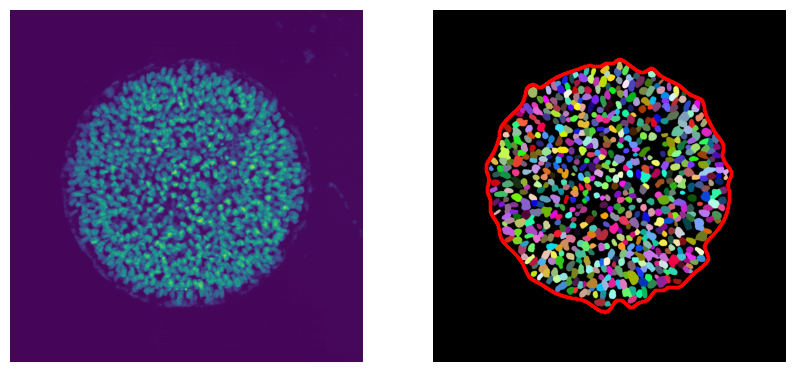

In [8]:
## plotting
distances, nucleus_centres, contour = seg.nearest_distance_from_edge(masks, return_full=True) # get contour for organoid edge
fig, ax = plt.subplots(1, 2, figsize=(10,5))
dapi_image = tiff.imread(dapi_image_path)
ax[0].imshow(dapi_image)
ax[0].axis("off")
seg.plot_mask(masks, ax[1], origin="upper")
ax[1].scatter(contour[:,1], contour[:,0], s=2, color="red", alpha=0.5)

[  0.         127.36950243 254.73900485 382.10850728 509.47800971]


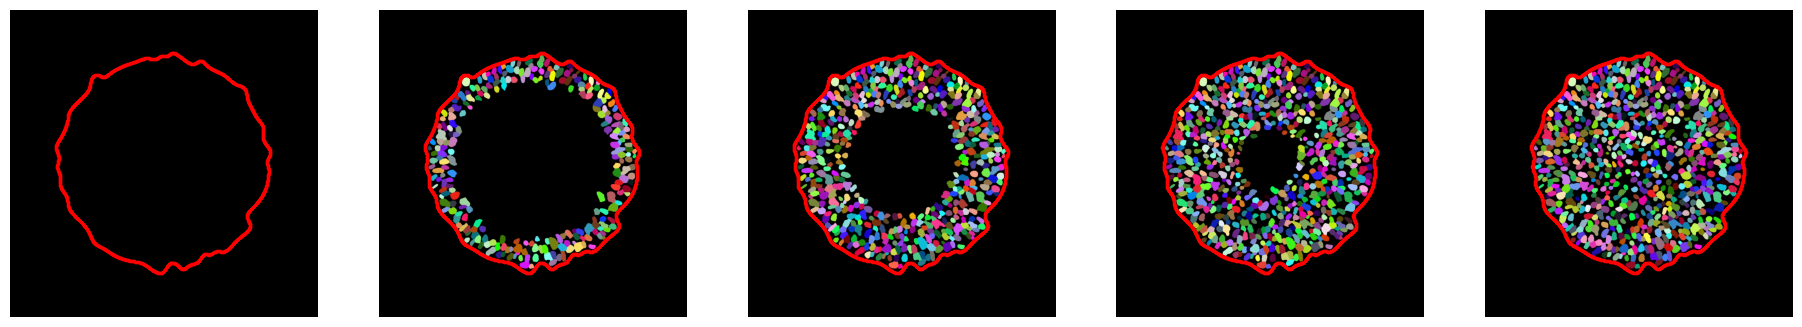

In [9]:
distances, nucleus_centres, contour = seg.nearest_distance_from_edge(masks, return_full=True)
# discretised distances to plot
distance_array = np.linspace(0, np.max(distances), 5)
print(distance_array)

fig, ax = plt.subplots(1, 5, figsize=(23,4))
ax = ax.flatten()
for i in range(len(distance_array)):
    subdistances = distances < distance_array[i]
    subcells = np.sort(np.unique(masks))[1:][subdistances]
    seg.plot_selected_masks(masks, subcells, ax[i])
    ax[i].scatter(contour[:,1], contour[:,0], s=2, color="red", alpha=0.5)

In [10]:
full_image_path = os.path.join(images_path, single_image_name+".tif")
save_data_path = os.path.join(save_data_folder_path, single_image_name+".csv")

# save intensity dataframe 
# dataframe = seg.mask_to_dataframe(full_image_path, masks, pixel_size, save_data_path)
# load intensity dataframe
dataframe = pd.read_csv(save_data_path)

In [11]:
dataframe.head()

,Unnamed: 0,cell_id,distance,channel_1,channel_2,channel_3,channel_4
0,0,1,8.671516,891.563795,684.257361,143.754635,345.641221
1,1,2,7.205677,680.076854,730.061483,145.860759,538.614828
2,2,3,10.466530,809.652133,659.145024,152.210427,451.643602
3,3,4,7.882391,837.715223,828.997375,173.296588,387.867454
4,4,5,15.377870,679.384858,601.567823,154.785489,481.584648


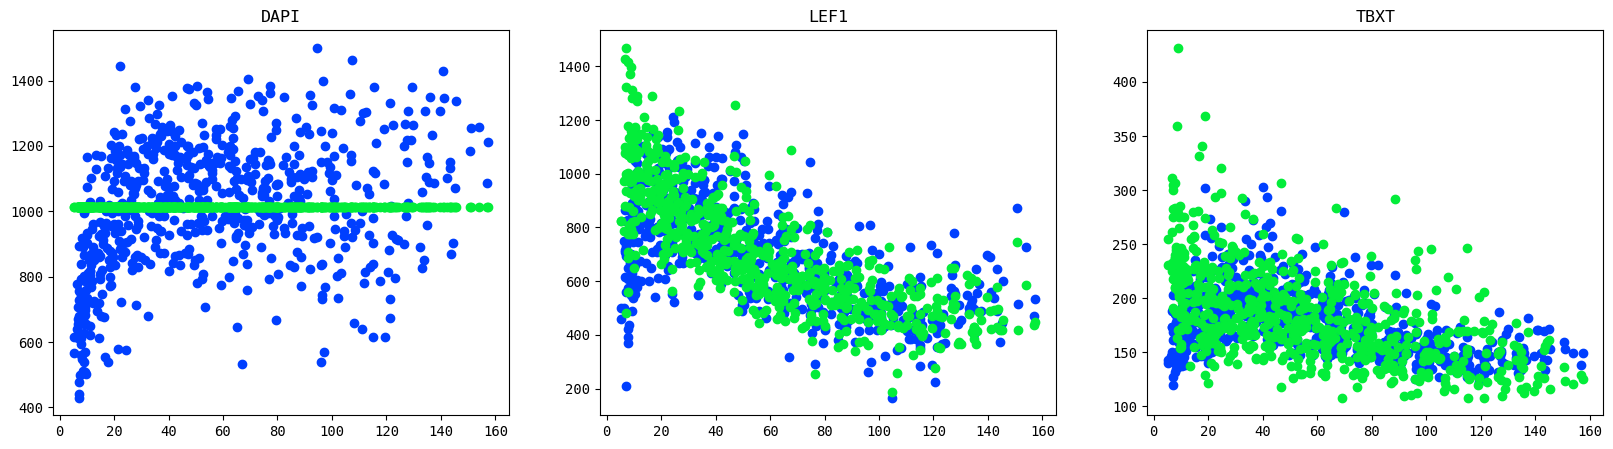

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
channel_names = {"channel_1":"DAPI", "channel_2":"LEF1", "channel_3":"TBXT"}
keys = list(channel_names.keys())
signal_names = list(channel_names.values())
dapi_signal = dataframe["channel_1"]
mean_dapi = np.mean(dapi_signal)
distance = dataframe["distance"]

for i in range(len(channel_names)):
    intensities = dataframe[keys[i]]
    dapi_norm_intensities = intensities * mean_dapi / dapi_signal
    ax[i].scatter(distance, intensities, label="Raw Intensity")
    ax[i].scatter(distance, dapi_norm_intensities, label="Norm Intensity")
    ax[i].set_title(signal_names[i])